In [1]:
using PyCall
np = pyimport("numpy")

PyObject <module 'numpy' from '/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/numpy/__init__.py'>

In [2]:
freq = 143.0
int_freq = Int(freq)

143

In [3]:
using HDF5

flux_143 = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(143.0).h5", "flux");

flux = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "flux")
θ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "theta")
ϕ = h5read("/tigress/zequnl/radio/lagache_sed_massage/catalog_$(freq).h5", "phi");

In [4]:
using XGPaint
using Healpix
hp = pyimport("healpy")

using PyPlot
using Unitful, UnitfulAstro
import PhysicalConstants.CODATA2018: BoltzmannConstant, PlanckConstant, SpeedOfLightInVacuum

# CHANGE FOR DIFFERENT FREQUENCY ==========================
# print(KCMB_to_Jy_factor(freq * 1u"GHz"))

const TCMB = 2.725u"K"
xf(ν) = float(PlanckConstant) * ν / float(BoltzmannConstant) / TCMB
MJy_mul(ν) = 1.05e3 * expm1(xf(ν))^2 * exp(-xf(ν)) * (ν/100u"GHz")^(-4)
tSZ_mul(ν) = 1e6u"1/K" * TCMB * (xf(ν) * (exp(xf(ν))+1) / expm1(xf(ν)) - 4)

┌ Info: Precompiling XGPaint [af630e4a-6754-4ec2-ab8a-f9f8b9ebafbf]
└ @ Base loading.jl:1278
┌ Info: Precompiling PhysicalConstants [5ad8b20f-a522-5ce9-bfc9-ddf1d5bda6ab]
└ @ Base loading.jl:1278


tSZ_mul (generic function with 1 method)

In [5]:
MJy_mul(freq * 1u"GHz"), tSZ_mul(freq * 1u"GHz")

(2634.1729406697013, -2.8341160526987785e6)

# Generate Radio Map

In [6]:
nside = 4096
m_radio = Map{Float64,RingOrder}(nside)
# flux_cut = 7e-3
# cut_array = flux_143 .< flux_cut  # in Jy
# XGPaint.catalog2map!(m_radio, flux[cut_array], θ[cut_array], ϕ[cut_array])
XGPaint.catalog2map!(m_radio, flux, θ, ϕ)

MJy_factor = MJy_mul(freq * 1u"GHz")
m_radio .*= MJy_factor / 1e6;  # CONVERT TO muK, note that our maps are in Jy/sr

In [7]:
using FITSIO

m_cib = readMapFromFITS("/tigress/zequnl/websky/cib_nu0$(int_freq).fits", 1, Float64);
m_cib.pixels .*= MJy_factor

tSZ_factor = tSZ_mul(freq * 1u"GHz")
m_tsz = readMapFromFITS("/tigress/zequnl/websky/tsz.fits", 1, Float64);
m_tsz .*= tSZ_factor;

In [8]:
ENV["SCRATCH"] = "/tigress/zequnl/xgpaint/"
@time halo_pos, halo_mass = read_halo_catalog_hdf5(
    joinpath(ENV["SCRATCH"],"websky_halos-light.hdf5"));

 21.896947 seconds (349.88 k allocations: 25.735 GiB, 0.91% gc time)


In [9]:
# beamed_radio = hp.sphtfunc.smoothing(m_radio.pixels, fwhm=fwhm_100);
# beamed_cib = hp.sphtfunc.smoothing(m_cib.pixels, fwhm=fwhm_100);
# beamed_tsz = hp.sphtfunc.smoothing(m_tsz.pixels, fwhm=fwhm_100);

In [10]:
mass_cut_array = halo_mass .> 10^14.5
positions = halo_pos[:, mass_cut_array];

In [11]:
norm(x) = sqrt(x[1]^2 + x[2]^2 + x[3]^2)
unitize(x) = x ./ norm(x)

unitize (generic function with 1 method)

In [12]:
max_disc_in_arcmin = 6
max_disc = deg2rad(max_disc_in_arcmin / 60)

0.0017453292519943296

In [13]:
using ProgressMeter

function get_discs(beamed_map::Array{T}, res, pos) where T
#     res = beamed_map.resolution
    radii = T[]
    disc_fluxes = T[]
    
    num_halos = size(pos, 2)
    @showprogress for i in 1:num_halos
        pixel_inds = hp.query_disc(nside, unitize(positions[:,i]), max_disc) .+ 1
        append!(disc_fluxes, beamed_map[pixel_inds])
        vec1 = unitize(positions[:,i]) #pix2vecRing(res, vec2pixRing(res, positions[:,i]...))
        vec2 = hp.pixelfunc.pix2vec(res.nside, pixel_inds .- 1) #[pix2angRing(res, pixind) for pixind in pixel_inds]
#         angdists = [hp.rotator.angdist(vec1, [vec2[1][i_discpix], vec2[2][i_discpix]])[1] for i_discpix in 1:length(pixel_inds) ]
        angdists = hp.rotator.angdist(vec1, vec2)
        append!(radii, angdists)
    end
    
    return radii, disc_fluxes
end

get_discs (generic function with 1 method)

In [14]:
using Interpolations
spline(x, y) = scale(interpolate(y, BSpline(Cubic(Line(OnGrid())))), x)
# spline_∂ₓ(f, x_grid) = spline(x_grid, [Interpolations.gradient(f, x)[1] for x in x_grid])


spline (generic function with 1 method)

In [15]:
# function get_profile(m, res)
#     r, f = get_discs(m, res, positions)
#     Δr = max_disc/30
#     radial_coord = Δr/100:Δr:max_disc
#     cumulative_fluxes = [sum(f[r .< r₀]) for r₀ in radial_coord];
#     profile = spline_∂ₓ(spline(radial_coord, cumulative_fluxes), radial_coord)
#     return profile
# end

In [16]:
function get_profile(m, res)
    r, f = get_discs(m, res, positions)
    Δr = max_disc/30
    radial_coord = 0.0:Δr:max_disc
    cumulative_fluxes = [
        sum( f[((r₀-Δr) .< r) .& (r .< (r₀+Δr))] ) / (π * ((r₀+Δr)^2 - max(0.0, r₀-Δr)^2))
        for r₀ in radial_coord];
    cumulative_fluxes[1] = sum( f[r .< Δr] ) / (π * Δr^2) 
    
    profile = spline(radial_coord, cumulative_fluxes) #spline_∂ₓ(
        
#         , radial_coord)
    return profile
end

get_profile (generic function with 1 method)

In [17]:
mask = hp.read_map("/tigress/zequnl/websky/radiomask_143_7mJy.fits");

In [18]:
# profile_radio = get_profile(beamed_radio, m_radio.resolution)
# profile_tsz = get_profile(beamed_tsz, m_radio.resolution)
# profile_cib = get_profile(beamed_cib, m_radio.resolution);

profile_radio = get_profile(m_radio.pixels .* mask, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels .* mask, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels .* mask, m_radio.resolution);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15m
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [19]:
# r, fr = get_discs(m_radio.pixels, m_radio.resolution, positions)
# r, fsz = get_discs(beamed_tsz, m_radio.resolution, positions)

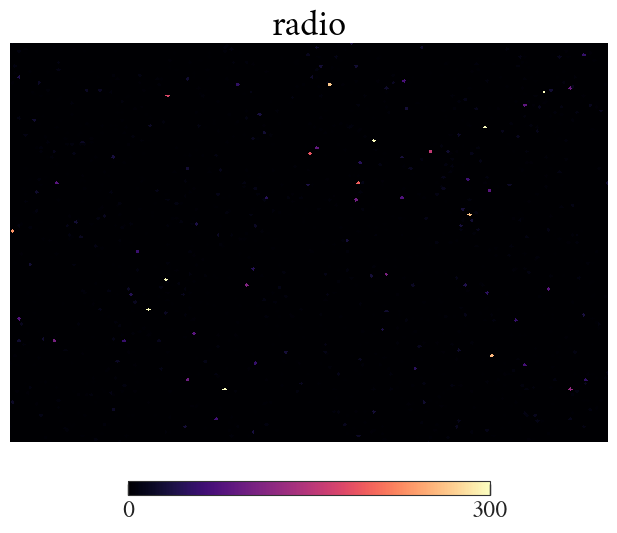

In [20]:
hp.cartview((m_radio.pixels), lonra=[-1,2], latra=[-1,1], max=3e2, title="radio")

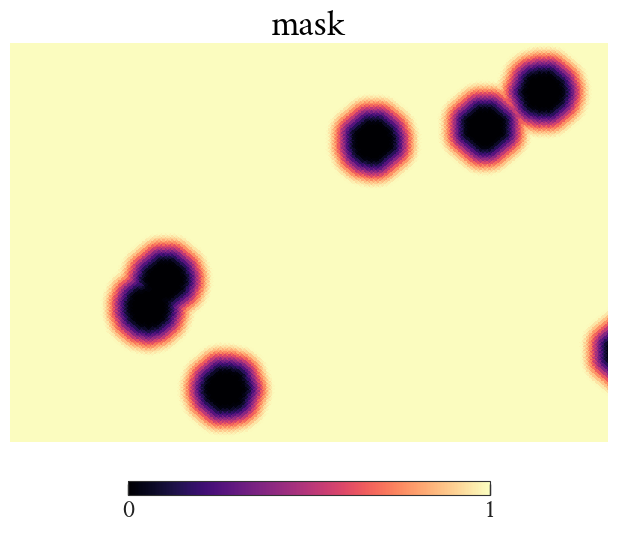

In [21]:
hp.cartview(mask, lonra=[-1,2], latra=[-1,1], title="mask")

In [22]:
sum(m_radio.pixels .* mask), sum(m_radio.pixels)

(7.382080646836439e7, 1.4086878676059645e8)

In [33]:
profile_radio = get_profile(m_radio.pixels .* mask, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels .* mask, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels .* mask, m_radio.resolution);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


In [ ]:
Δr = max_disc/30
plotting_r = Δr/10:max_disc/1000:(max_disc-Δr)
r_arcmin = rad2deg.(plotting_r) .* 60

plot(r_arcmin, profile_radio.(plotting_r), "-", label="radio")
plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ 10  , "-", label="|tSZ| / 10")
plot(r_arcmin, profile_cib.(plotting_r) ./ 10, "-", label="CIB / 10")
# plot(radial_coord, predict(approx, radial_coord), "-")
legend()
# yscale("log")
# title("unbeamed $(freq) GHz (masked)")
ylim(0.0, 1e13)
savefig("figures/unbeamed_143_masked.pdf")

In [29]:
profile_radio = get_profile(m_radio.pixels, m_radio.resolution)
profile_tsz = get_profile(m_tsz.pixels, m_radio.resolution)
profile_cib = get_profile(m_cib.pixels, m_radio.resolution);

Δr = max_disc/30
plotting_r = Δr/10:max_disc/1000:(max_disc-Δr)
r_arcmin = rad2deg.(plotting_r) .* 60;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


964-element Array{Float64,1}:
 0.020000000000000004
 0.026000000000000002
 0.032
 0.038000000000000006
 0.044000000000000004
 0.05
 0.056
 0.062
 0.068
 0.07400000000000001
 0.08000000000000002
 0.086
 0.092
 ⋮
 5.732
 5.738000000000001
 5.744
 5.75
 5.755999999999999
 5.762
 5.768000000000001
 5.774
 5.78
 5.786
 5.792000000000001
 5.798000000000001

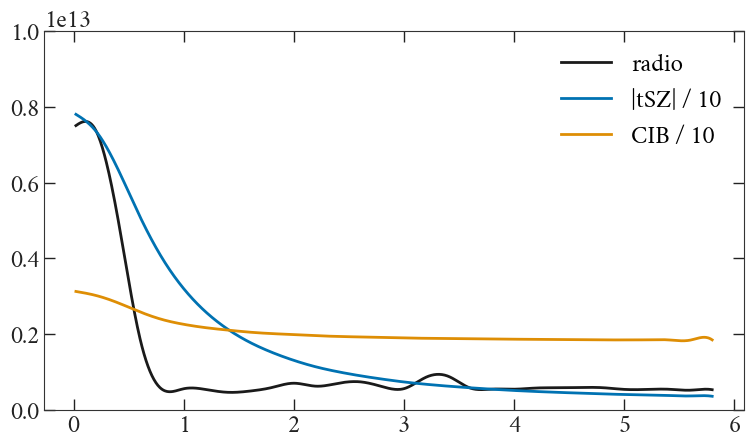

/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 4096
  warnings.warn("NSIDE = {0:d}".format(nside))
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))
/tigress/zequnl/conda_envs/ps/lib/python3.8/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You

In [32]:
plot(r_arcmin, profile_radio.(plotting_r), "-", label="radio")
plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ 10  , "-", label="|tSZ| / 10")
plot(r_arcmin, profile_cib.(plotting_r) ./ 10, "-", label="CIB / 10")
# plot(radial_coord, predict(approx, radial_coord), "-")
legend()
# yscale("log")
# title("unbeamed $(freq) GHz (unmasked, no flux cut)")
ylim(0.0, 1e13)
tight_layout()
savefig("figures/unbeamed_143_unmasked_no_cut.pdf")

In [25]:
# r_arcmin = rad2deg.(plotting_r) .* 60
# plot(r_arcmin, profile_radio.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="radio")
# plot(r_arcmin, abs.(profile_tsz.(plotting_r)) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="|tSZ|")
# plot(r_arcmin, profile_cib.(plotting_r) ./ ( π .* ((plotting_r .+ Δr/50).^2 - (plotting_r .- Δr/50).^2)), "-", label="CIB")
# # plot(radial_coord, predict(approx, radial_coord), "-")
# legend()
# yscale("log")
# title(freq)
# # ylim(0.0, 0.5e20)

In [26]:
rad2deg(sqrt(nside2pixarea(nside))) * 60

0.8588716029543515

In [27]:
360 * 60 / 3nside

1.7578125